In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os 
from scipy.signal import find_peaks, peak_prominences
import pandas as pd
from scipy import signal, fft
from datetime import datetime
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation
from signaltk import constants as cst
from arch import arch_model
from scipy.signal import detrend

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300

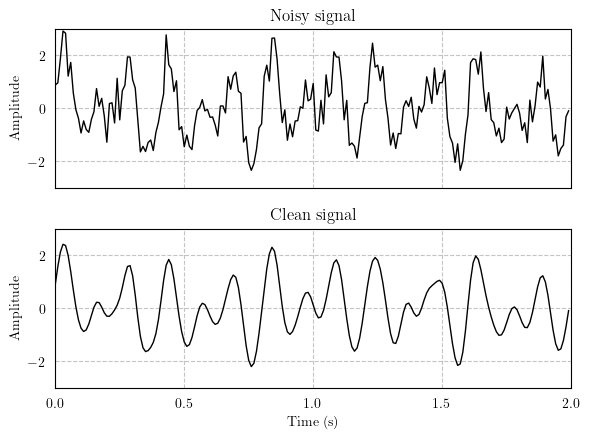

In [2]:
np.random.seed(0)  # For reproducibility

# --- Signal Parameters ---
frequency = 5  # Hz
amplitude = 1.0
sampling_rate = 100  # Samples per second
duration = 2  # Seconds

# --- Generate Time Vector ---
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# --- Generate Clean Sine Wave (sum of two frequencies for more complexity) ---
clean_signal = amplitude * np.sin(2 * np.pi * frequency * t) + amplitude * np.sin(2 * np.pi * frequency * 1.5 * t)

# --- Generate Noise ---
# Mean of the Gaussian noise (typically 0 for white noise)
noise_mean = 0
# Standard deviation of the Gaussian noise (controls noise intensity)
noise_std_dev = 0.5
noise = np.random.normal(noise_mean, noise_std_dev, len(t))

# --- Add Noise to Signal ---
noisy_signal = clean_signal + noise

# --- Butterworth Low-pass Filter Design ---
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.25 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# --- Filter Parameters ---
cutoff = 7  # Hz, just above the signal frequency
order = 4

# --- Apply Low-pass Filter to Noisy Signal ---
filtered_signal = butter_lowpass_filter(noisy_signal, cutoff, sampling_rate, order)


# --- Plotting to match the pasted image ---
fig, axs = plt.subplots(nrows=2, figsize=(6, 4.5), sharex=True, sharey=True)

axs[0].plot(t, noisy_signal, 'k', linewidth=1, zorder=25)
axs[0].set_title('Noisy signal')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, filtered_signal, 'k', linewidth=1, zorder=25)
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Clean signal')

for ax in axs:
    ax.set_xlim(0, duration)
    ax.set_ylim(-3, 3)
    ax.set_xticks(np.arange(0, duration + 0.5, 0.5))
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/signal_illustration.pdf", dpi=DPI, transparent=True)
plt.show()

### Signals

In [3]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [4]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")

In [5]:
subset = [
    "UNITED AIR LINES INC",
    "APPLE COMPUTER INC",
    "APPLE INC",
    "FORD MOTOR CO",
    "FORD MOTOR CO DEL",
    "WALMART INC",
    "GENERAL MOTORS CO",
    "GENERAL ELECTRIC CO",
    "AMERICAN TELEPHONE & TELEG CO",
    "GENERAL MOTORS CORP",
    "PROCTER & GAMBLE CO",
    "PEPSICO INC",
    "APPLE INC"
]

crsp[crsp["comnam"].isin(subset)].xs("2024-12-31")

,comnam,ret,shrout,vol,prc,altprc,exchcd,siccd,ticker,cusip,exchange,industry,ret_adj,excess_ret,dollar_vol,mktcap
permno,,,,,,,,,,,,,,,,
12060,GENERAL ELECTRIC CO,-0.082839,1082294.0,1115095.0,166.78999,166.78999,1,3511,GE,36960430,NYSE,Manufacturing,-0.082839,-0.086539,185986683.89905,180515805.43706
12369,GENERAL MOTORS CO,-0.039576,1099596.0,2109221.0,53.27,53.27,1,3711,GM,37045V10,NYSE,Manufacturing,-0.039576,-0.043276,112358202.67,58575478.92
13856,PEPSICO INC,-0.061395,1371989.0,1413091.0,152.06,152.06,3,2086,PEP,71344810,NASDAQ,Manufacturing,-0.061395,-0.065095,214874617.46,208624647.34
14593,APPLE INC,0.055155,15115823.0,9710426.0,250.42,250.42,3,3571,AAPL,03783310,NASDAQ,Manufacturing,0.055155,0.051455,2431684878.92,3785304395.66
18163,PROCTER & GAMBLE CO,-0.064766,2355042.0,1338912.0,167.64999,167.64999,1,2844,PG,74271810,NYSE,Manufacturing,-0.064766,-0.068466,224468583.41088,394822767.74958
25785,FORD MOTOR CO DEL,-0.110512,3903437.0,12187469.0,9.9,9.9,1,3711,F,34537086,NYSE,Manufacturing,-0.110512,-0.114212,120655943.1,38644026.3
55976,WALMART INC,-0.021,8033386.0,3821318.0,90.35,90.35,1,5311,WMT,93114210,NYSE,Retail,-0.021000,-0.0247,345256081.3,725816425.1


In [6]:
id_mapping = {
    "Apple Inc.": 14593,
    "Walmart Inc": 55976,
}

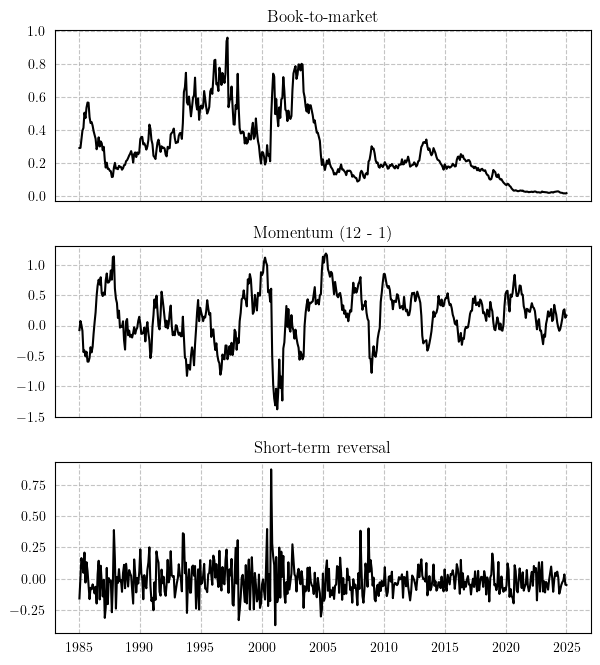

In [7]:
sig = {"b2m": "Book-to-market", "mom_12_1": "Momentum (12 - 1)", "strev": "Short-term reversal"}
_id = 55976  # Walmart Inc.
_id = 16847
_id = 12490  # IBM
# _id = 12369
# _id = 12060
_id = 18163  # Procter & Gamble Co.
_id = 13856  # PepsiCo Inc.
_id = 14593  # Apple Inc.
start_dt = datetime(1984, 12, 31)
fig, axs = plt.subplots(nrows=len(sig), figsize=(6, 2.25 * len(sig)), sharex=True, sharey=False)

for ax, s in zip(axs, sig):
    s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)[s].dropna()
    ax.plot(s_vals, c="black")
    # ax.set_xlim(0, duration)
    # ax.set_ylim(-3, 3)
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.set_title(sig[s])
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/inv_signal_example.pdf", dpi=DPI, transparent=True)
plt.show()

In [8]:
# https://www.mathworks.com/help/ident/ref/iddata.detrend.html

<Axes: >

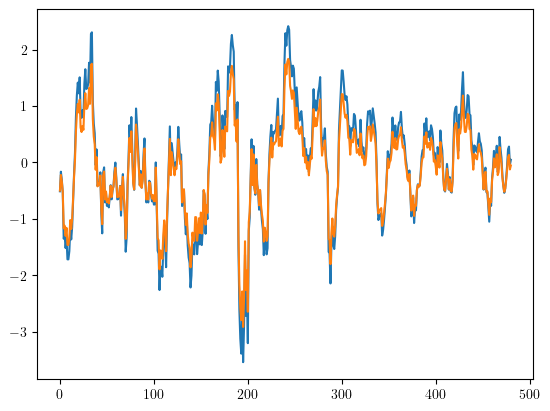

In [9]:
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, Normalizer, KernelCenterer

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = StandardScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = RobustScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

<Axes: >

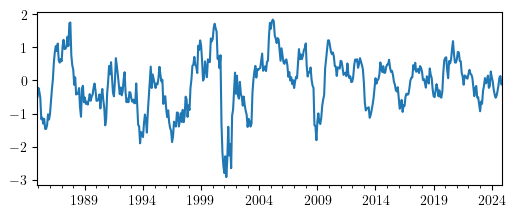

In [10]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
transformer = RobustScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame()).flatten(), index=s_vals.index).plot(figsize=(6, 2.25))

### Use the below to simulate signals

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# from pykalman import KalmanFilter

# # --- 1. Simulate a Non-Stationary Signal (same as before) ---
# np.random.seed(42)
# time_points = 500
# t = np.arange(time_points)
# true_mean = 10 + 5 * np.sin(t / 50) + 0.02 * t
# true_std_dev = 2 + 1 * np.cos(t / 80) + 0.01 * t
# true_variance = true_std_dev**2
# signal = np.random.normal(loc=true_mean, scale=true_std_dev, size=time_points)

# plt.figure(figsize=(14, 6))
# plt.plot(t, signal, label='Observed Signal', alpha=0.7)
# plt.plot(t, true_mean, 'r--', label='True Mean')
# plt.plot(t, true_mean + true_std_dev, 'g:', label='True Std Dev Bands')
# plt.plot(t, true_mean - true_std_dev, 'g:')
# plt.title('Simulated Non-Stationary Signal')
# plt.xlabel('Time Step')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()


In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# from filterpy.kalman import KalmanFilter
# from filterpy.common import Q_discrete_white_noise

# # --- 1. Simulate a Non-Stationary Signal (same as before) ---
# np.random.seed(42) # For reproducibility

# time_points = len(s_vals)
# t = np.arange(time_points)

# # Generate the signal
# signal = detrend(s_vals)


# # --- 2. Implement the Adaptive Kalman Filter using filterpy ---

# # Initialize the KalmanFilter object
# # State dimension (dim_x) = 1 (for mean)
# # Measurement dimension (dim_z) = 1 (for signal sample)
# kf = KalmanFilter(dim_x=1, dim_z=1)

# # Initial state estimation (x) and its covariance (P)
# kf.x = np.array([[signal[0]]]) # Initial estimate of the mean
# kf.P = np.array([[100.0]])   # High initial uncertainty in mean estimate

# # State transition function (F)
# # Mean follows a random walk, so F is just 1
# kf.F = np.array([[1.]])

# # Measurement function (H)
# # Observation is directly the mean, so H is just 1
# kf.H = np.array([[1.]])

# # Process noise covariance (Q)
# # Represents how much the true mean is allowed to change between steps
# # Tune this value: larger Q means filter trusts new measurements more.
# Q_mu_scalar = 0.01 # Same as Q_mu from previous examples
# kf.Q = np.array([[Q_mu_scalar]])

# # Adaptive R_k parameters
# # Initial estimate of measurement noise covariance (R_k)
# # Use variance of initial segment as a start
# R_k_scalar = np.var(signal[:12])
# kf.R = np.array([[R_k_scalar]]) # Set initial R for the filter

# alpha_R = .05 # Smoothing factor for R_k adaptation (0 to 1)
# # alpha_R = 0.10 # Smoothing factor for R_k adaptation (0 to 1)

# # Store results
# mean_estimates = [kf.x[0,0]] # Initial mean estimate
# std_dev_estimates = [] # We'll derive this from the adaptive R_k

# # Main Kalman Filter Loop
# for i in range(1, time_points):
#     z_k = signal[i] # Current observation

#     # --- Prediction Step ---
#     kf.predict()

#     # --- Update Step ---
#     kf.update(z_k)

#     # Store estimated mean
#     mean_estimates.append(kf.x[0,0])

#     # --- Adapt R_k (Measurement Noise Covariance) ---
#     # The innovation (measurement residual) for the current step is stored in kf.y
#     innovation = kf.y[0,0]

#     # Update R_k using EWMA of squared innovations
#     R_k_scalar = alpha_R * (innovation**2) + (1 - alpha_R) * R_k_scalar
#     kf.R = np.array([[R_k_scalar]]) # Update filter's R for the next iteration

#     # Store the square root of R_k as our estimated standard deviation
#     std_dev_estimates.append(np.sqrt(R_k_scalar))

# # Pad std_dev_estimates for the initial point (since it starts from i=1)
# std_dev_estimates.insert(0, np.sqrt(np.var(signal[:12]))) # Use initial R_k's sqrt

# # --- 3. Plotting Results ---
# plt.figure(figsize=(14, 8))

# plt.subplot(2, 1, 1)
# plt.plot(t, signal, label='Observed Signal', alpha=0.7)
# # plt.plot(t, true_mean, 'r--', label='True Mean')
# plt.plot(t, mean_estimates, 'b-', label='KF Estimated Mean (Adaptive R)')
# plt.title('Kalman Filter Estimation of Time-Varying Mean (Adaptive R with FilterPy)')
# plt.xlabel('Time Step')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 1, 2)
# # plt.plot(t, true_std_dev, 'r--', label='True Standard Deviation')
# plt.plot(t, std_dev_estimates, 'm-', label='KF Estimated Std Dev (from Adaptive R)')
# plt.title('Estimated Standard Deviation (from Adaptive Measurement Noise)')
# plt.xlabel('Time Step')
# plt.ylabel('Standard Deviation')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [13]:
# s_vals.sub(s_vals.mean()).div(s_vals.std()).plot(figsize=(6, 2.25))
# xx = pd.Series(detrend(s_vals), index=s_vals.index).div(pd.Series(std_dev_estimates, index=s_vals.index))
# xx.div(xx.std()).plot(figsize=(6, 2.25))
# plt.show()

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from filterpy.kalman import KalmanFilter

# # For reproducibility
# np.random.seed(42)

# ## ---------------------------------------------------
# ## Step 1: Generate Synthetic Heteroscedastic Data
# ## ---------------------------------------------------
# # The data will have a true mean that follows a sine wave and two noise regimes.
# n_samples = 500
# dt = 0.1

# # True underlying mean
# true_mean = 0.5 * np.sin(np.arange(n_samples) * dt * 0.2) + 10

# # Create heteroscedastic noise (low noise -> high noise -> low noise)
# noise_std = np.ones(n_samples) * 0.2  # Low noise regime
# noise_std[150:350] = 1.5             # High noise regime
# noise = np.random.randn(n_samples) * noise_std

# # Create the final measured time series
# measurements = true_mean + noise

# ## ---------------------------------------------------
# ## Step 2: Initialize the Kalman Filter
# ## ---------------------------------------------------
# # We are tracking one variable (the mean), so dim_x=1
# # We are measuring one variable (the value), so dim_z=1
# kf = KalmanFilter(dim_x=1, dim_z=1)

# # Define the model matrices
# kf.x = np.array([measurements[0]])  # Initial state (mean)
# kf.P = np.array([[1.]])             # Initial state covariance (uncertainty)
# kf.F = np.array([[1.]])             # State transition matrix
# kf.H = np.array([[1.]])             # Measurement function
# kf.Q = np.array([[0.01]])           # Process noise (how much we expect the mean to change)
# # kf.R will be updated dynamically in the loop

# ## ---------------------------------------------------
# ## Step 3: Run the Filter and Adapt R
# ## ---------------------------------------------------
# # Lists to store results
# estimated_means = []
# estimated_variances = []
# residuals = []
# residual_window_size = 20 # Window to estimate R

# for z in measurements:
#     # Predict the next state
#     kf.predict()

#     # Update the filter with the new measurement
#     kf.update(z)

#     # Store the results
#     estimated_means.append(kf.x[0])
#     estimated_variances.append(kf.P[0, 0])

#     # --- Adaptive R Estimation ---
#     # Calculate the residual (innovation)
#     residual = z - kf.H @ kf.x_prior
#     residuals.append(residual[0])
    
#     # Use a moving window of residuals to estimate R for the *next* step
#     if len(residuals) > residual_window_size:
#         # Variance of recent residuals is a good estimate for R
#         # Add a small epsilon for numerical stability
#         r_est = np.var(residuals[-residual_window_size:]) + 1e-6 
#         kf.R = np.array([[r_est]])

# # Convert lists to numpy arrays for plotting
# estimated_means = np.array(estimated_means)
# estimated_variances = np.array(estimated_variances)
# estimated_std = np.sqrt(estimated_variances)

# ## ---------------------------------------------------
# ## Step 4: Visualize the Results
# ## ---------------------------------------------------
# plt.style.use('seaborn-v0_8-whitegrid')
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# # Plot 1: Mean Estimation
# ax1.plot(measurements, 'o', markersize=3, color='gray', alpha=0.6, label='Noisy Measurements')
# ax1.plot(true_mean, 'k--', lw=2, label='True Mean')
# ax1.plot(estimated_means, color='b', lw=2, label='Kalman Filter Estimate')
# ax1.fill_between(
#     range(n_samples),
#     estimated_means - 1.96 * estimated_std,
#     estimated_means + 1.96 * estimated_std,
#     color='b',
#     alpha=0.2,
#     label='95% Confidence Interval'
# )
# ax1.set_title('Kalman Filter Estimation of Conditional Mean', fontsize=16)
# ax1.set_ylabel('Value')
# ax1.legend()
# ax1.grid(True)

# # Plot 2: Uncertainty (Standard Deviation)
# ax2.plot(noise_std, 'k--', lw=2, label='True Noise Std Dev')
# ax2.plot(estimated_std, color='b', lw=2, label='Estimated State Std Dev (sqrt(P))')
# ax2.set_title('Filter Uncertainty vs. True Noise', fontsize=16)
# ax2.set_xlabel('Time Step')
# ax2.set_ylabel('Standard Deviation')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

## Signal filtering

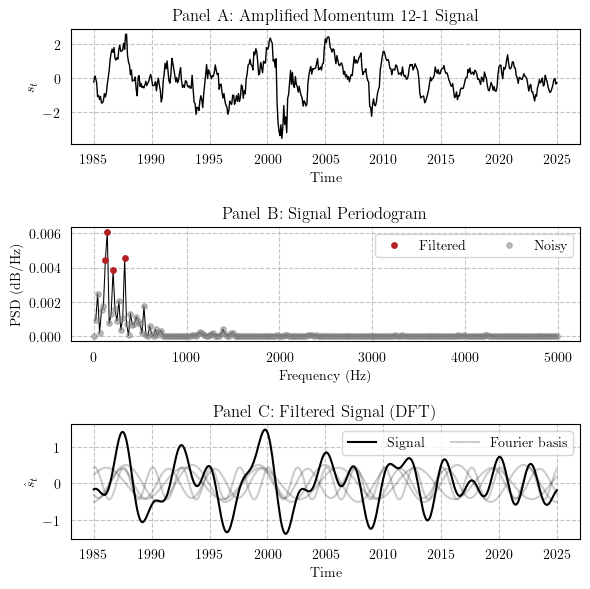

In [15]:
raw_signals_subset = raw_signals.loc[start_dt:].xs(_id, level=1)[["b2m", "mom_12_1"]].dropna()
s_vals = raw_signals_subset["mom_12_1"]
x = pd.Series(detrend(s_vals), index=s_vals.index)
x = x.sub(x.mean()).div(x.std())  # TODO: to be replace by proper LNA

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
# cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
# filt_val = cat.cluster_centers_.flatten().argmax()
# filt_flags = cat.labels_ == filt_val

hard_thresh = .003
filt_flags = Pxx_den > hard_thresh

filt_fhat = np.where(filt_flags, fhat, 0)
filt_x = fft.irfft(filt_fhat, n=n)

s_m = x.copy()
s_mhat = filt_x.copy()

# ----------------------------------------------------------
# Plot
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=False, sharey=False)

# Raw signal
axs[0].plot(x.index, x.values, 'k', linewidth=1, zorder=25)

# Periodogram

axs[1].scatter(f[filt_flags], Pxx_den[filt_flags], color='firebrick', s=15, zorder=25)
axs[1].scatter(f[~filt_flags], Pxx_den[~filt_flags], c="gray", s=15, zorder=25, alpha=0.5)
axs[1].legend(["Filtered", "Noisy"], ncols=2, loc='upper right', fontsize=10)
# axs[1].semilogy(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
axs[1].plot(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
# axs[1].set_ylim([5e-8, 1E-1])

# Filtered signal
axs[2].plot(x.index, filt_x, 'k', linewidth=1.5, zorder=25)

nn = len(filt_flags)
for i in range(nn):
    if filt_flags[i]:
        flag_i = np.array([False] * nn)
        flag_i[i] = True
        filt_i = np.where(flag_i, fhat, 0)
        fhat_i = fft.irfft(filt_i, n=n)
        axs[2].plot(x.index, fhat_i, 'k', linewidth=1.5, zorder=25, alpha=.2)

axs[2].legend(["Signal", "Fourier basis"], ncols=2, loc='upper right', fontsize=10)

for ax in axs:
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

axs[0].set_xlabel("Time")
axs[1].set_xlabel("Frequency (Hz)")
axs[2].set_xlabel("Time")
axs[0].set_ylabel("$s_{t}$")
axs[1].set_ylabel("PSD (dB/Hz)")
axs[2].set_ylabel("$\hat{s}_{t}$")
axs[0].set_title("Panel A: Amplified Momentum 12-1 Signal")
axs[1].set_title("Panel B: Signal Periodogram")
axs[2].set_title("Panel C: Filtered Signal (DFT)")

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/signal_fft.pdf", dpi=DPI, transparent=True)
plt.show()

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


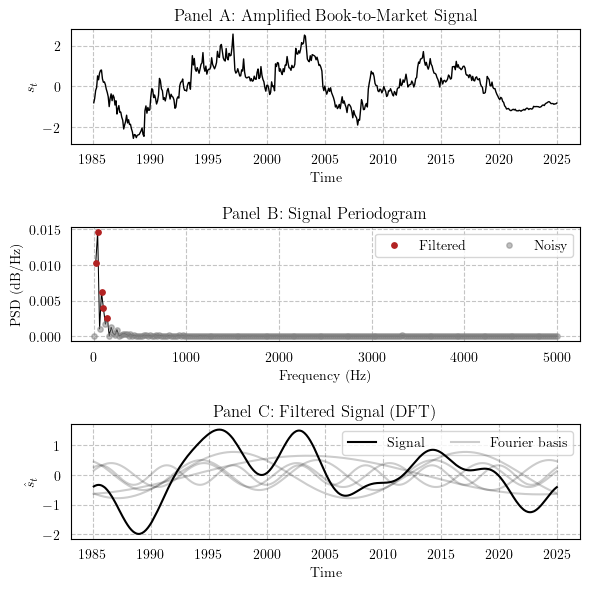

In [16]:
raw_signals_subset = raw_signals.loc[start_dt:].xs(_id, level=1)[["b2m", "mom_12_1"]].dropna()
s_vals = raw_signals_subset["b2m"]
# x = pd.Series(detrend(s_vals), index=s_vals.index)
# x = x.sub(x.mean()).div(x.std())  # TODO: to be replace by proper LNA

x = pd.Series(detrend(s_vals), index=s_vals.index)
mdl = arch_model(x, p=1, o=0, q=1, mean="ARX", lags=1)
res = mdl.fit(disp="off")
x = x.div(res.conditional_volatility).dropna()
x = x.sub(x.mean()).div(x.std())

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
# cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
# filt_val = cat.cluster_centers_.flatten().argmax()
# filt_flags = cat.labels_ == filt_val

hard_thresh = .002
filt_flags = Pxx_den > hard_thresh

filt_fhat = np.where(filt_flags, fhat, 0)
filt_x = fft.irfft(filt_fhat, n=n)

s_v = x.copy()
s_vhat = filt_x.copy()

# ----------------------------------------------------------
# Plot
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=False, sharey=False)

# Raw signal
axs[0].plot(x.index, x.values, 'k', linewidth=1, zorder=25)

# Periodogram

axs[1].scatter(f[filt_flags], Pxx_den[filt_flags], color='firebrick', s=15, zorder=25)
axs[1].scatter(f[~filt_flags], Pxx_den[~filt_flags], c="gray", s=15, zorder=25, alpha=0.5)
axs[1].legend(["Filtered", "Noisy"], ncols=2, loc='upper right', fontsize=10)
# axs[1].semilogy(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
axs[1].plot(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
# axs[1].set_ylim([5e-8, 1E-1])

# Filtered signal
axs[2].plot(x.index, filt_x, 'k', linewidth=1.5, zorder=25)

nn = len(filt_flags)
for i in range(nn):
    if filt_flags[i]:
        flag_i = np.array([False] * nn)
        flag_i[i] = True
        filt_i = np.where(flag_i, fhat, 0)
        fhat_i = fft.irfft(filt_i, n=n)
        axs[2].plot(x.index, fhat_i, 'k', linewidth=1.5, zorder=25, alpha=.2)

axs[2].legend(["Signal", "Fourier basis"], ncols=2, loc='upper right', fontsize=10)

for ax in axs:
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

axs[0].set_xlabel("Time")
axs[1].set_xlabel("Frequency (Hz)")
axs[2].set_xlabel("Time")
axs[0].set_ylabel("$s_{t}$")
axs[1].set_ylabel("PSD (dB/Hz)")
axs[2].set_ylabel("$\hat{s}_{t}$")
axs[0].set_title("Panel A: Amplified Book-to-Market Signal")
axs[1].set_title("Panel B: Signal Periodogram")
axs[2].set_title("Panel C: Filtered Signal (DFT)")

plt.tight_layout(h_pad=1.5)
plt.show()

Text(0, 0.5, '$s_{t}$')

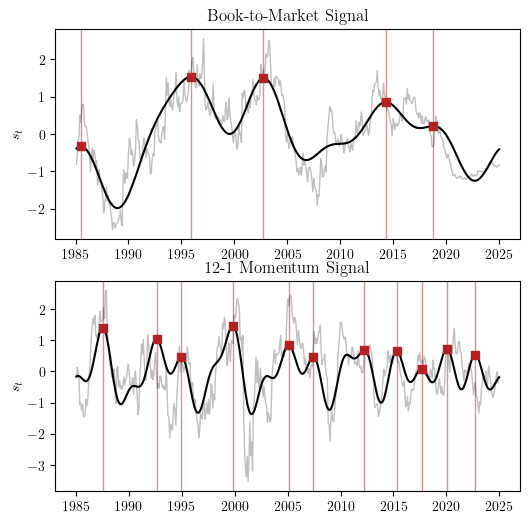

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=False, sharey=False)

axs[0].plot(s_v.index, s_v, 'k', linewidth=1, zorder=20, alpha=0.25)
axs[0].plot(s_v.index, s_vhat, 'k', linewidth=1.5, zorder=25)

axs[1].plot(s_m.index, s_m, 'k', linewidth=1, zorder=20, alpha=0.25)
axs[1].plot(s_m.index, s_mhat, 'k', linewidth=1.5, zorder=25)

# Peaks
pks = find_peaks(s_vhat)[0]
for p in pks:
    axs[0].scatter(x=s_v.index[p], y=s_vhat[p], zorder=30, color='firebrick', s=35, marker="s")
    axs[0].axvline(x=s_v.index[p], color='firebrick', linestyle='-', alpha=0.5, linewidth=1)

pks = find_peaks(s_mhat, prominence=0.25)[0]
for p in pks:
    axs[1].scatter(x=s_m.index[p], y=s_mhat[p], zorder=30, color='firebrick', s=35, marker="s")
    axs[1].axvline(x=s_m.index[p], color='firebrick', linestyle='-', alpha=0.5, linewidth=1)

axs[0].set_title("Book-to-Market Signal")
axs[1].set_title("12-1 Momentum Signal")
axs[0].set_ylabel("$s_{t}$")
axs[1].set_ylabel("$s_{t}$")


In [18]:
v_pro = peak_prominences(s_vhat, peaks=find_peaks(s_vhat)[0])[0]
m_pro = peak_prominences(s_mhat, peaks=find_peaks(s_mhat)[0])[0]

In [19]:
m_peak_wt = pd.Series(m_pro, index=find_peaks(s_mhat)[0]).reindex(s_mhat.index).fillna(0)
v_peak_wt = pd.Series(v_pro, index=find_peaks(s_vhat)[0]).reindex(s_vhat.index).fillna(0)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

# TODO: Matching should involve the importance of the peak

In [177]:
from statsmodels.tsa.stattools import ccf
import numpy as np

optimal_lag = np.argmax(np.abs(ccf(s_m[1:], s_v)))
optimal_lag

np.int64(423)

In [178]:
test_values = range(400)

res = {}
s_vhat2 = pd.Series(s_vhat)
for t in test_values:
    s_m2 = s_m.copy().shift(t)
    s_mhat2 = pd.Series(s_mhat.copy()).shift(t)
    diff = s_vhat2 - s_mhat2
    res[t] = np.sqrt(diff.pow(2).mean())    

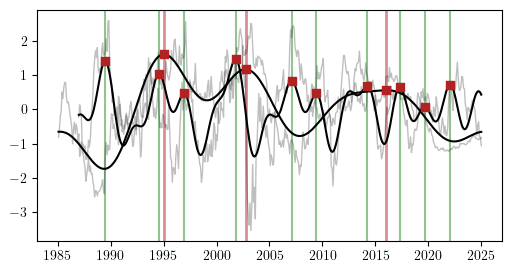

In [175]:
SHIFT = 24
fig, ax = plt.subplots(nrows=1, figsize=(6, 3), sharex=False, sharey=False)

ax.plot(s_v.index, s_v, 'k', linewidth=1, zorder=20, alpha=0.25)
ax.plot(s_v.index, s_vhat, 'k', linewidth=1.5, zorder=25)
sm_2 = s_m.copy().shift(SHIFT)
sm_2hat = pd.Series(s_mhat.copy()).shift(SHIFT).values
ax.plot(sm_2.index, sm_2, 'k', linewidth=1, zorder=20, alpha=0.25)
ax.plot(sm_2.index, sm_2hat, 'k', linewidth=1.5, zorder=25)
pks = find_peaks(s_vhat, prominence=0.25)[0]
for p in pks:
    ax.scatter(x=s_v.index[p], y=s_vhat[p], zorder=30, color='firebrick', s=35, marker="s")
    ax.axvline(x=s_v.index[p], color='firebrick', linestyle='-', alpha=0.5, linewidth=2)
pks = find_peaks(sm_2hat, prominence=0.25)[0]
for p in pks:
    ax.scatter(x=sm_2.index[p], y=sm_2hat[p], zorder=30, color='firebrick', s=35, marker="s")
    ax.axvline(x=sm_2.index[p], color='forestgreen', linestyle='-', alpha=0.5, linewidth=1.5)

In [25]:
shifted_ts = pd.DataFrame([s_vhat, s_mhat], index=["v", "m"]).T
shifted_ts["m"] = shifted_ts["m"].shift(SHIFT)
shifted_ts.index = s_v.index
shifted_ts.dropna(inplace=True)

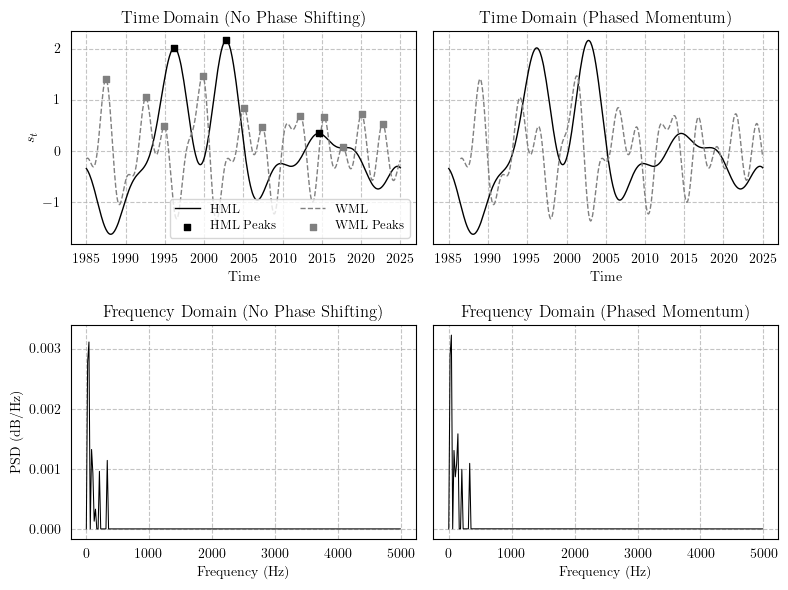

In [26]:
SHIFT = 18

shifted_ts = pd.DataFrame([s_vhat, s_mhat], index=["v", "m"]).T
shifted_ts["m"] = shifted_ts["m"].shift(SHIFT)
shifted_ts.index = s_v.index
# shifted_ts.dropna(inplace=True)

ts_cfg = {
    "HML": {
        "raw": s_v,
        "filtered": s_vhat,
        "aligned": s_vhat,
        "peaks": find_peaks(s_vhat, prominence=0.25)[0],
        "plot_kwargs": {
            "color": "black",
            "linewidth": 1,
            "ls": "-",
            "zorder": 25
        },
        "shifted":shifted_ts["v"]
    },
    "WML": {
        "raw": s_m,
        "filtered": s_mhat,
        "peaks": find_peaks(s_mhat, prominence=0.25)[0],
        "plot_kwargs": {
            "color": "gray",
            "linewidth": 1,
            "ls": "--",
            "zorder": 25
        },
        "shifted": shifted_ts["m"]
    }
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='row', sharey='row')

# Panel 1: Fitlered signals
for i, (title, cfg) in enumerate(ts_cfg.items()):
    axs[0, 0].plot(cfg["raw"].index, cfg["filtered"], **cfg["plot_kwargs"], label=title)
    axs[0, 0].scatter(x=cfg["raw"].iloc[cfg["peaks"]].index, y=cfg["filtered"][cfg["peaks"]], zorder=30, color=cfg["plot_kwargs"]["color"], s=25, marker="s", label=f"{title} Peaks")

# Panel 2: PSD
# No phase shifting
s_blend = (s_vhat + s_mhat) / 2
n = len(s_blend)
fhat = fft.rfft(s_blend, n)
f, Pxx_den = signal.periodogram(s_blend, 10e3, scaling='density')
# axs[1, 0].semilogy(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
axs[1, 0].plot(f, Pxx_den, 'k', linewidth=.75, zorder=20)
# axs[1, 0].set_ylim([5e-8, 1E-1])

# After phase shifting
s_blend = shifted_ts.mean(axis=1)
n = len(s_blend)
fhat = fft.rfft(s_blend, n)
f, Pxx_den = signal.periodogram(s_blend, 10e3, scaling='density')
axs[1, 1].plot(f, Pxx_den, 'k', linewidth=.75, zorder=20)
# axs[1, 1].semilogy(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
# axs[1, 1].set_ylim([5e-8, 1E-1])

# Panel 1: Fitlered signals
for i, (title, cfg) in enumerate(ts_cfg.items()):
    axs[0, 1].plot(cfg["shifted"].index, cfg["shifted"], **cfg["plot_kwargs"], label=title)
    # axs[0, 0].scatter(x=cfg["raw"].iloc[cfg["peaks"]].index, y=cfg["filtered"][cfg["peaks"]], zorder=30, color=cfg["plot_kwargs"]["color"], s=25, marker="s", label=f"{title} Peaks")

axs[0, 0].set_ylabel("$s_{t}$")
axs[1, 0].set_ylabel("PSD (dB/Hz)")
axs[0, 0].set_title("Time Domain (No Phase Shifting)")
axs[1, 0].set_title("Frequency Domain (No Phase Shifting)")
axs[1, 1].set_title("Frequency Domain (Phased Momentum)")
axs[0, 1].set_title("Time Domain (Phased Momentum)")

axs[0, 0].legend(ncols=2, fontsize=9).set_zorder(35)

for i in range(2):
    axs[1, i].set_xlabel("Frequency (Hz)")
    axs[0, i].set_xlabel("Time")

for ax in axs.flatten():
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/mom_val_shifting.pdf", dpi=DPI, transparent=True)
plt.show()

# TODO: mark the peaks, find a visualization for alignment